# Travaux Pratique : Analyse des extrêmes de température en Antarctique

M2 CClimAT, Université de Bourgogne  
22 novembre 2024  
Victoire Buffet, PhD student @ IGE, Université Grenoble Alpes/Université de Bourgogne.  
victoire.buffet@univ-grenoble-alpes.fr


---

### Objectifs du TP

Dans ce TP, vous allez :
1. Explorer un ensemble de données climatiques (températures en Antarctique).
2. Enlever la variation cyclique d'une série temporelle.
2. Appliquer des techniques d'analyse d'extrêmes à l'aide de bibliothèques Python.
3. Visualiser les résultats et interpréter les statistiques des événements extrêmes.

Ce TP vise à approfondir vos connaissances sur les méthodes utilisées pour caractériser les extrêmes météorologiques.

---

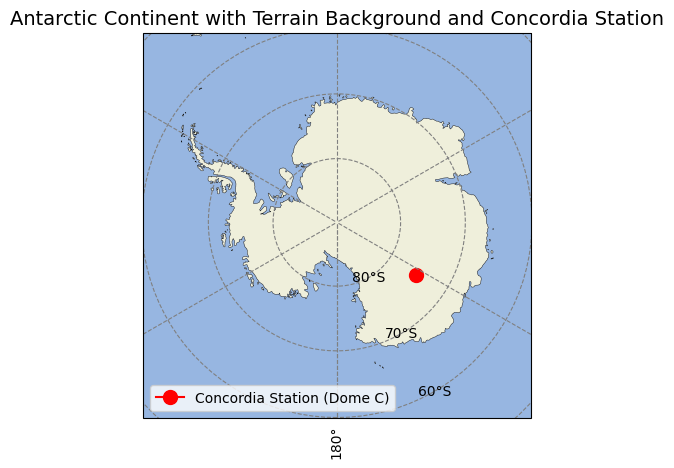

In [181]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Coordinates for Concordia Station
concordia_lat = -75.1  # 75.1°S
concordia_lon = 123.35  # 123.35°E

# Create a figure and axes with the South Polar projection
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection=ccrs.SouthPolarStereo())

# Add terrain as the background
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE,linewidth=0.3)# Add the Antarctic coastlines

# Add Concordia Station
ax.plot(concordia_lon, concordia_lat, marker='o', color='red', markersize=10,
        transform=ccrs.PlateCarree(), label="Concordia Station (Dome C)")

# Add gridlines
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add a legend
plt.legend(loc="lower left")

# Set map extent to focus on Antarctica
ax.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())

# Add a title
plt.title("Antarctic Continent with Terrain Background and Concordia Station", fontsize=14)

# Show the plot
plt.show()

## Etape 1 : Préparation
### 1.1 Importer les bibliothèques nécessaires
Commencez par importer les bibliothèques Python essentielles pour le TP :

In [308]:
from pyextremes import get_extremes, get_return_periods, EVA, get_model, models
from pyextremes.plotting import plot_extremes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genextreme

### 1.2 Importer la donnée
Il faut importer la donnée de température de la station Antarctique que nous allons analyser : Concordia. Charge le fichier avec ```pandas```, qu'on a importée sous le nom ```pd``` dans la boite précédente. ```pandas``` est la libraire MVP python pour ouvrir des tableaux : 

In [119]:
data = pd.read_csv('./Concordia.csv', sep=',')

Affiche le tableau ```data``` : 

In [120]:
data

,DATE,TX,Tmean
0,1985-01-01,-22.6,-28.64
1,1985-01-02,-24.1,-29.55
2,1985-01-03,-24.1,-29.20
3,1985-01-04,-22.4,-28.01
4,1985-01-05,-22.0,-28.96
...,...,...,...
13384,2022-04-26,-66.5,-68.74
13385,2022-04-27,-68.2,-69.97
13386,2022-04-28,-55.8,-63.29
13387,2022-04-29,-55.2,-59.73


La commande ```.head()``` permet d'afficher juste les premières lignes pour aller plus vite :

In [121]:
data.head()

,DATE,TX,Tmean
0,1985-01-01,-22.6,-28.64
1,1985-01-02,-24.1,-29.55
2,1985-01-03,-24.1,-29.20
3,1985-01-04,-22.4,-28.01
4,1985-01-05,-22.0,-28.96


In [122]:
# Affiche les colonnes du tableau "data"
data.columns

Index(['DATE', 'TX', 'Tmean'], dtype='object')

> **Q1**. Quelles sont les colonnes constituant le tableau ?


On peut accéder à une colonne en faisant ```data['nom_de_ma_colonne']```. Teste en affichant la colonne 'DATE' :

In [123]:
data['DATE']

0        1985-01-01
1        1985-01-02
2        1985-01-03
3        1985-01-04
4        1985-01-05
            ...    
13384    2022-04-26
13385    2022-04-27
13386    2022-04-28
13387    2022-04-29
13388    2022-04-30
Name: DATE, Length: 13389, dtype: object

> **Q2**. Quelle est la fréquence temporelle de ce jeu de donnée ?

Nous, humains, voyons que ce qu'il y a dans ```data['DATE']``` est une date, mais l'ordinateur pour l'instant ne voit qu'une suite de caractères. Il faut lui indiquer que cette colone est une date en convertissant la colonne avec ```pd.to_datetime(ma_colonne)``` où ```ma_colonne = data['nom_de_ma_colonne']```.

In [124]:
dates = pd.to_datetime(data['DATE'])

Affichons la nouvelle colonne contenant les dates :

In [125]:
dates

0       1985-01-01
1       1985-01-02
2       1985-01-03
3       1985-01-04
4       1985-01-05
           ...    
13384   2022-04-26
13385   2022-04-27
13386   2022-04-28
13387   2022-04-29
13388   2022-04-30
Name: DATE, Length: 13389, dtype: datetime64[ns]

> **Q3.** Qu'est ce qu'il y a de différent entre ```data['DATE']``` et ```dates``` ?

Ensuite, nous allons remplacer l'index de notre tableau de données ```data``` qui est pour l'instant juste une numérotation des lignes, par les dates.

In [126]:
data.index = dates

Affiche notre tableau ```data``` : 

In [127]:
data.head()

,DATE,TX,Tmean
DATE,,,
1985-01-01,1985-01-01,-22.6,-28.64
1985-01-02,1985-01-02,-24.1,-29.55
1985-01-03,1985-01-03,-24.1,-29.20
1985-01-04,1985-01-04,-22.4,-28.01
1985-01-05,1985-01-05,-22.0,-28.96


On voit que la date est en double car elle maintenant à la fois dans l'index (en gras à gauche) et dans la colonne ```'DATE'```. Supprimons donc la colonne ```'DATE'``` car on a pas besoin de l'avoir en double.

In [128]:
data = data.drop(columns=['DATE'])

Affiche notre tableau ```data``` : 

In [129]:
data.head()

,TX,Tmean
DATE,,
1985-01-01,-22.6,-28.64
1985-01-02,-24.1,-29.55
1985-01-03,-24.1,-29.20
1985-01-04,-22.4,-28.01
1985-01-05,-22.0,-28.96


On veut regarder les extrêmes de température, donc on veut gardeur seulement la colonne du maximum journalier de température ```TX```. **Supprime la colonne ```Tmean``` en complétant le code ci dessous** : 

In [130]:
#### À toi de jouer ! 
data = data.drop(columns=[])

## Etape 2 : Nettoyage de la donnée

### 2.1 Etat des lieux

Affichons déjà rapidement notre série temporelle de température maximale à la station Antarctique Concordia : 

<Axes: xlabel='DATE'>

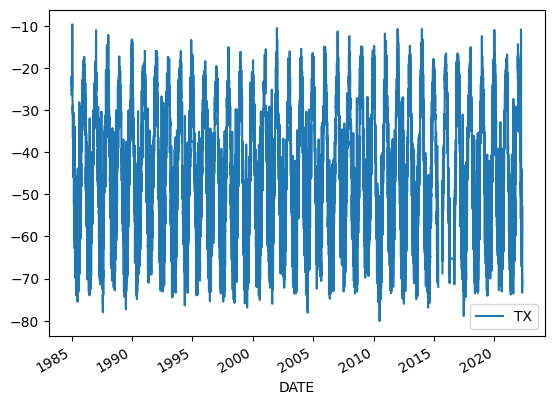

In [135]:
data.plot()

> **Q4.** Que vois tu sur cette figure ?

Oui, il manque un peu de données, affichons quelles années sont touchées : 

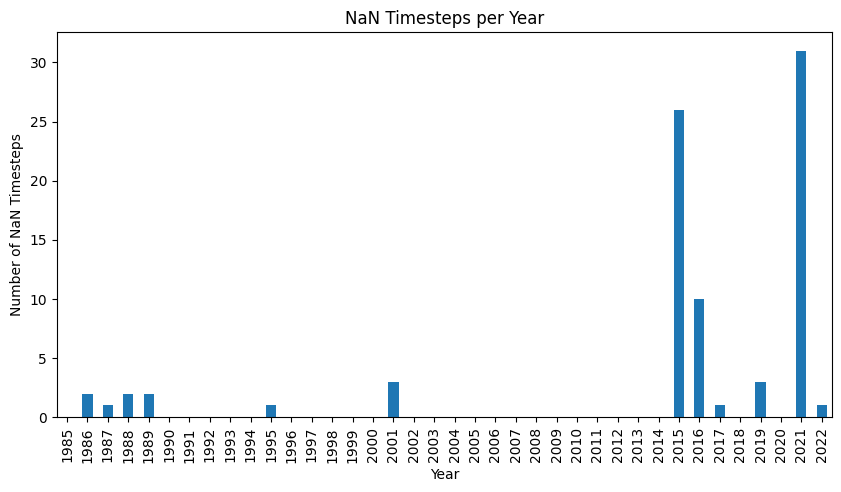

In [147]:
nan_counts_per_year = data['TX'].isnull().groupby(data.index.year).sum()
nan_counts_per_year.plot(kind='bar', figsize=(10, 5))
plt.xlabel('Year')
plt.ylabel('Number of NaN Timesteps')
plt.title('NaN Timesteps per Year')
plt.show()

Il manque un peu de donnée, surtout récemment, jusqu'à 8% environ de donnée manquante. C'est pas idéal mais pas dramatique.  Il a une deuxième chose à remarquer, qui ne concerne pas la donnée en soit mais la variation naturelle de la donnée. 

Allez, je t'aide un peu, zoommons sur une année (sélectionnons 1996), tu vas voir où je veux en venir.

/var/folders/54/pkzn72h1027chpfymzrw4x440000gn/T/ipykernel_784/2099721295.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  data['1996'].plot()


<Axes: xlabel='DATE'>

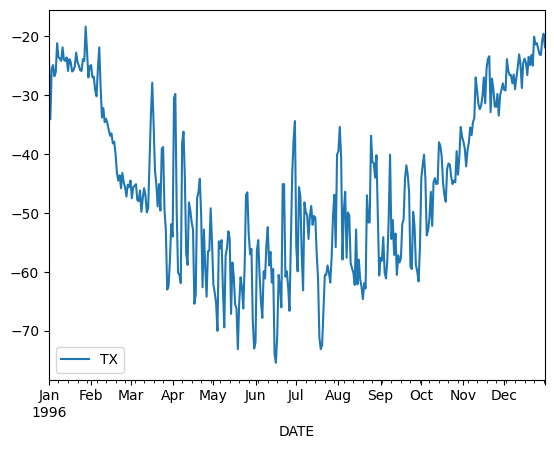

In [148]:
data['1996'].plot()

En effet, on observe un fort cycle annuel, avec des températures nettement plus froides durant l'hiver austral (juin-juillet-août) que pendant le reste de l'année. Ce cycle est particulièrement marqué, car la station Concordia se trouve profondément à l'intérieur du continent antarctique.

Si l'on extrait la température maximale annuelle à partir de cette série temporelle brute, on va extraire que des dates durant l'été austral (Décembre-Janvier-Février). Il faut donc enlever ce cycle annuel pour extraire les **anomalies** de température (l'écart par rapport à la moyenne de ce même jour). 

### 2.2 Calcul du cycle annuel moyen

In [155]:
# Étape 1 : Ajouter la colonne "jour de l'année"
data["day_of_year"] = data.index.dayofyear
# Affichons notre tableau avec sa nouvelle colonne : 
data.head()

,TX,day_of_year
DATE,,
1985-01-01,-22.6,1
1985-01-02,-24.1,2
1985-01-03,-24.1,3
1985-01-04,-22.4,4
1985-01-05,-22.0,5


In [156]:
# Étape 2 : Calculer la moyenne pour chaque jour de l'année
mean_cycle = data.groupby("day_of_year")["TX"].mean()

Text(0, 0.5, 'Valeur moyenne')

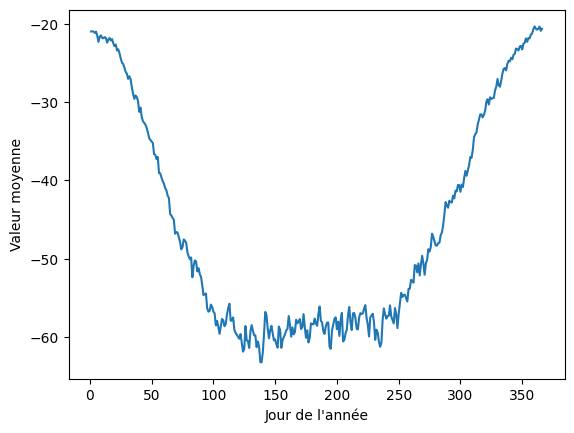

In [324]:
#Affiche le cycle annuel : 
mean_cycle.plot()
# Ajouter des labels pour les axes
plt.xlabel("Jour de l'année")
plt.ylabel("Valeur moyenne")

On voit que le cycle annuel est très bruité, surtout en hiver austral (Juin-Juillet-Aout) car il y a de fortes variations durant cette période, puisqu'il a énormément de glace de mer autour du continent, l'effet continental est donc accentué, les masses d'air sont moins stabilisées par l'océan. Il faut prendre en compte cette variabilité d'abord en lissant la moyenne (ici moyenne glissante sur 10 jours):


Text(0, 0.5, 'Valeur moyenne lissée')

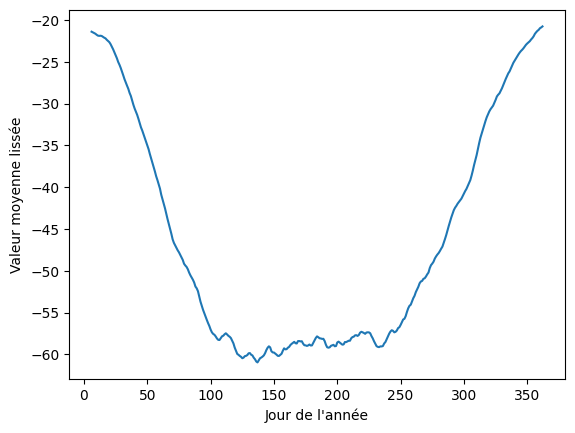

In [323]:
smoothed_mean_cycle = mean_cycle.rolling(window=10, center=True).mean()
#Affiche le cycle annuel lissé : 
smoothed_mean_cycle.plot()
# Ajouter des labels pour les axes
plt.xlabel("Jour de l'année")
plt.ylabel("Valeur moyenne lissée")

Puis aussi en prenant en compte la variabilité interannuelle de chaque période, pour calculer les **anomalies normalisées** $\frac{x - \mu}{\sigma}$ où $\mu$ est la moyenne, $x$ la donnée brute et $\sigma$ l'écart type de TX pour un jour de l'année donnée.

Calculons donc l'écart type pour chaque jour de l'année et lissons le :

In [164]:
std_cycle = data.groupby("day_of_year")["TX"].std()

Text(0, 0.5, 'Écart type journalier lissé')

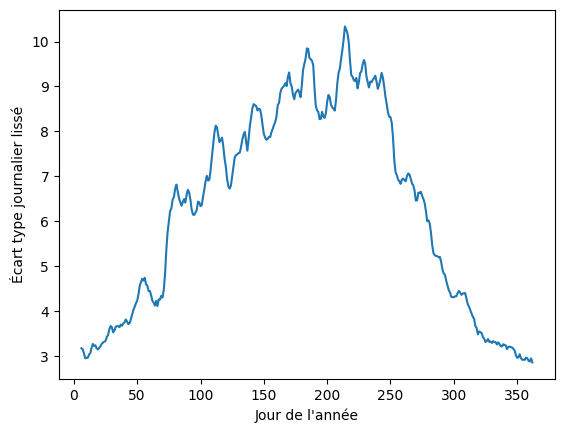

In [360]:
#Affiche le cycle annuel : 
smoothed_std_cycle = std_cycle.rolling(window=10, center=True).mean()
smoothed_std_cycle.plot()

# Ajouter des labels pour les axes
plt.xlabel("Jour de l'année")
plt.ylabel("Écart type journalier lissé")

### 2.3 Calcul des anomalies normalisées

In [244]:
data["normalized_TX"] = ((data["TX"] - data["day_of_year"].map(smoothed_mean_cycle)) / data["day_of_year"].map(smoothed_std_cycle))
data["ano_TX"] = ((data["TX"] - data["day_of_year"].map(smoothed_mean_cycle)))

On obtient donc une série temporelle de maximum de température journalier à Concordia **normalisée** ✨ : 

<Axes: xlabel='DATE'>

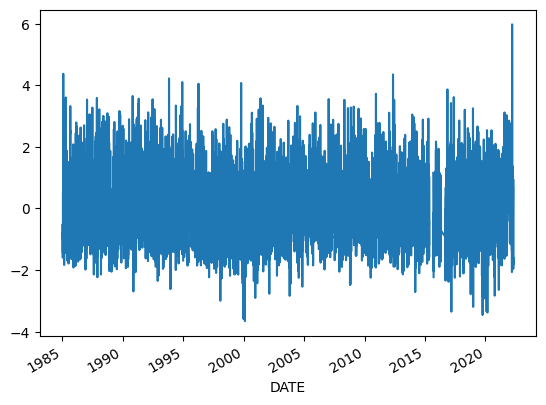

In [245]:
data["normalized_TX"].plot()

## Etape 3 : Analyse des extrêmes

Rentrons dans le vif du sujet !

Nous souhaitons connaitre le temps de retour des valeurs extrêmes de température à Concordia.  

### 3.1 Calcul du temps de retour sans distinction des extrêmes
D'abord calculons le temps de retour de toutes les valeurs de température (normalisées) à Concordia, en considérant toutes les valeurs, toute la série temporelle.  

Pour cela, il faut :
- Classer la série dans l'ordre descendant
- Attribuer à chaque valeur son rang (ordre descendant)
- Calculer la période de retour $T_{k}$ pour chaque valeur de rank $k$ avec la formule : $T = \frac{n+1}{k} \times \frac{1}{365}$  où $n$ est le nombre de pas de temps dans notre série temporelle.

In [305]:
# Sort precipitation data (descending order)
df_sorted = data["normalized_TX"].sort_values(ascending=False)

# Get rank (descending order, with dense method to handle ties)
df_rank = df_sorted.rank(ascending=False, method="dense")

# Calculate return periods
n = len(data["normalized_TX"])
return_period = (n + 1) / df_rank
return_period_year = return_period * (1/365)
# Combine results into a DataFrame for convenience
results = pd.DataFrame({
    'Normalized TX': df_sorted,
    'Rank': df_rank,
    'Return Period': return_period_year
})
results.head()

,Normalized TX,Rank,Return Period
DATE,,,
2022-03-18,5.973681,1.0,36.684932
2022-03-19,5.232999,2.0,18.342466
2022-03-17,4.983239,3.0,12.228311
2022-03-20,4.522372,4.0,9.171233
1985-01-25,4.369394,5.0,7.336986


Ici, on retrouve en n°1 **la vague de chaleur extrême en Antarctique de l'Est** qui a eu lieu en **Mars 2022** !! Un papier extraordinaire a été fait sur cet évènement par un collectif de scientifiques avec qui je travaille : https://doi.org/10.1175/JCLI-D-23-0175.1

In [300]:
data['ano_TX'][results.index[0]]

37.542147937411094

**Il faisait 37°C de plus que la moyenne à Concordia ! C'est un record !**

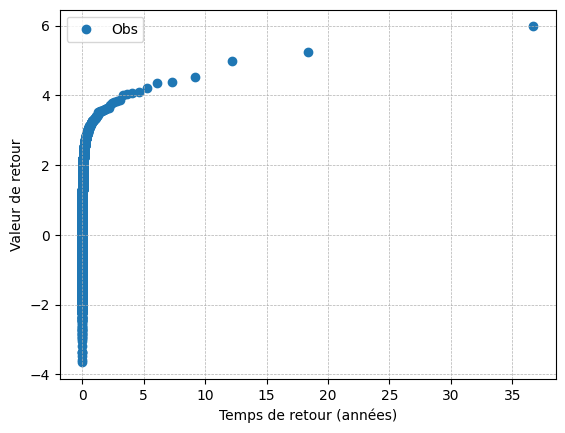

In [306]:
# Plot Return Periods vs Precipitation
plt.scatter(results['Return Period'], results['Normalized TX'], marker='o', label="Obs")
plt.xlabel("Temps de retour (années)")
plt.ylabel("Valeur de retour")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.show()

> **Q4.** D'après cette méthode, quel est le temps de retour de l'anomalie normalisée de TX qui a eu lieu à Concordia le 2022-03-18 ?

### 3.2 Calcul du temps de retour en ne considérant que les extrêmes

Maintenant on veut seulement considérer les maximums annuels d'anomalie normalisée de TX. C'est donc la méthode de sélection des extrêmes appélés **"Block Maxima"** vue dans le cours que nous allons utiliser. Les extrêmes obtenus par cette méthode sont théoriquement distribués selon la **loi d'extremum généralisée (Generalized Extreme Value in English, GEV)** qui continent 3 types de distribution : 
- Type I : Gumbel ($\xi = 0$)
> Queue légère : pour beaucoup de variables.
- Type II : Frechet ($\xi > 0$)
> Queue lourde : pour la précipitation, le débit. 
- Type III : Weibull ($\xi < 0$)
> Queue bornée : pour la témpérature, vitesse du vent, niveau des mers.

> **Q4.** Puisque nous avond 38 années dans notre série temporelle, à combien de valeur extrêmes devons nous nous attendre ?

#### 3.2.1 Extraction des extrêmes

Utilisons la libraire ```pyextremes```, qui est faite pour extraire et traiter les extrêmes de façon très simple.

La fonction ```get_extremes``` extrait les extrêmes de la série temporelle **régulière** (pas de temps journalier) et **indépendante** (c'est à dire "la chance d'avoir un maximum est la même partout", c'est pour ça qu'on a enlevé le cycle annuel). 


L'argument ```ts``` prend notre série temporelle, l'argument ```method``` prend le type (```BM``` ici pour **Block Maxima**) et l'argument ```block_size``` pour la taille du bloc, ici 1 an/365jours.

In [246]:
extremes = get_extremes(
    ts=data["normalized_TX"],
    method="BM",
    block_size="365.2425D",
)

On peut organiser les extrêmes par ordre descendant : 

In [309]:
extremes.sort_values(ascending=False).head()

DATE
2022-03-18    5.973681
1985-01-25    4.369394
2012-05-09    4.347770
1993-10-26    4.218822
1994-11-30    4.099016
Name: normalized_TX, dtype: float64

Maintenant, regardons à quel mois sont associés ces extrêmes : 

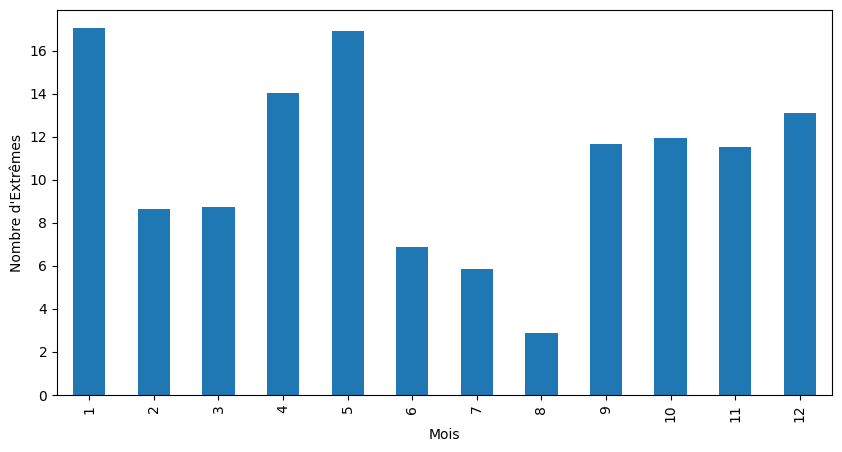

In [269]:
Xtreme_counts_per_month = extremes.groupby(extremes.index.month).sum()
Xtreme_counts_per_month.plot(kind='bar', figsize=(10, 5))
plt.xlabel('Mois')
plt.ylabel("Nombre d'Extrêmes")
plt.show()

> **Q5.** Que vois tu ? Est ce que le fait d'enlever le cycle annuel de la donnée brute a permis d'avoir une répartition équillibrée entre les mois ?

#### 3.2.2 Affichons les extrêmes 

(<Figure size 768x480 with 1 Axes>,
 <Axes: xlabel='DATE', ylabel='normalized_TX'>)

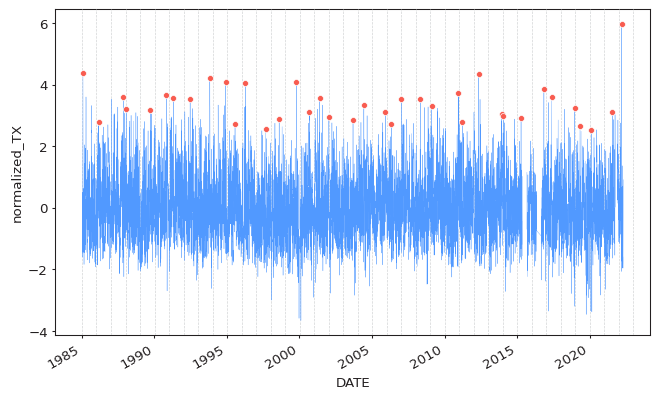

In [259]:
plot_extremes(ts=data["normalized_TX"],
    extremes=extremes,
    extremes_method="BM", 
              block_size="365.2425D", extremes_type="high",
              figsize=(8, 5))

#### 3.2.3 Estimation empirique des temps de retour

In [291]:
#À toi de jouer !  Remplis ce qu'il manque : 

return_periods = get_return_periods(
    ts=,
    extremes=,
    extremes_method=,
    extremes_type=,
    block_size=,
    return_period_size=,
    plotting_position="weibull",
)

In [307]:
return_periods =  return_periods.sort_values("return period", ascending=False)
return_periods.head()

,normalized_TX,exceedance probability,return period
DATE,,,
2022-03-18,5.973681,0.025641,39.00
1985-01-25,4.369394,0.051282,19.50
2012-05-09,4.347770,0.076923,13.00
1993-10-26,4.218822,0.102564,9.75
1994-11-30,4.099016,0.128205,7.80


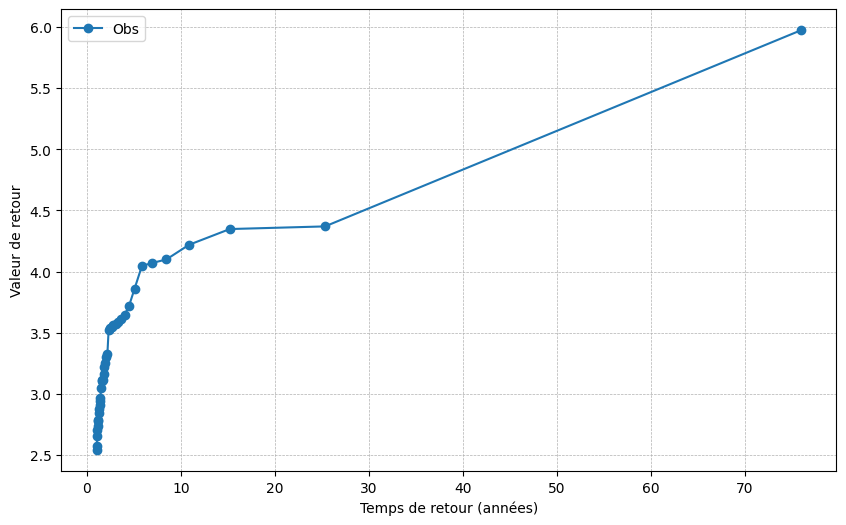

In [275]:
plt.figure(figsize=(10, 6))

# Plot return levels against return periods
plt.plot(return_periods['return period'], return_periods['normalized_TX'], marker='o', label="Obs")

# Customize plot
plt.xlabel("Temps de retour (années)")
plt.ylabel("Valeur de retour")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()

# Show plot
plt.show()

> **Q6.** D'après cette méthode, quel est le temps de retour de la vague de chaleur de Mars 2022 à Concordia? Comment c'est par rapport à la méthode qui prennait en compte toutes les données et pas seulement les extrêmes (partie 3.1) ?

> **Q7.** Et pour la température qu'il y a eu le 1985-01-25 à Concordia ?

#### 3.2.4 Ajustement statistique des temps de retour (modèle paramétrique)

Dans cette partie, on va approximer la distribution de nos extrêmes avec une fonction issue de la loi **loi d'extremum généralisée (Generalized Extreme Value in English, GEV)**. Pour ça, on va utiliser la classe ```EVA``` de ```pyextremes```.

Ici, on crée l'instance du modèle : 

In [310]:
model = EVA(data["normalized_TX"])

/opt/miniconda3/lib/python3.10/site-packages/pyextremes/eva.py:131: RuntimeWarning: 391 Null values found in `data` - removing invalid entries
  warnings.warn(message=message, category=RuntimeWarning)


Ensuite, comme dans la partie précédente, il faut récupérer les extrêmes avec la méthode de **Block Maxima**, le maximum annuel : 

In [311]:
#À toi de remplir ce qu'il manque!

model.get_extremes(
    method=,
    block_size= 
    ,)

Ensuite, on "fit" le modèle, c'est à dire, l'ordinateur essaye de minimiser l'écart entre des distributions de valeurs et nos données pour nous donner ce qui s'en rapporhce le plus.

In [356]:
model.fit_model()

Ici, on prend ```alpha = 0.95``` car on veut un intervalle de confiance de 95% et on demande d'afficher certains temps de retour.

In [357]:
summary = model.get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100, 250, 300,400, 500, 600,700,800,900, 1000],
    alpha=0.95,
    n_samples=1000,
)

/opt/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Affichons le résultat du modèle : 

In [358]:
summary

,return value,lower ci,upper ci
return period,,,
1.0,-inf,NaN,NaN
2.0,3.289711,3.108673,3.490130
5.0,3.822247,3.531212,4.141932
10.0,4.174833,3.799842,4.583476
25.0,4.620325,4.143069,5.136942
50.0,4.950817,4.392737,5.553080
100.0,5.278868,4.629801,5.967297
250.0,5.710802,4.965443,6.517153
300.0,5.796622,5.030151,6.626402


Cette fois ci sous forme de figure : 

(<Figure size 768x768 with 4 Axes>,
 (<Axes: title={'center': 'Return value plot'}, xlabel='Return period', ylabel='normalized_TX'>,
  <Axes: title={'center': 'Probability density plot'}, xlabel='normalized_TX', ylabel='Probability density'>,
  <Axes: title={'center': 'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <Axes: title={'center': 'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

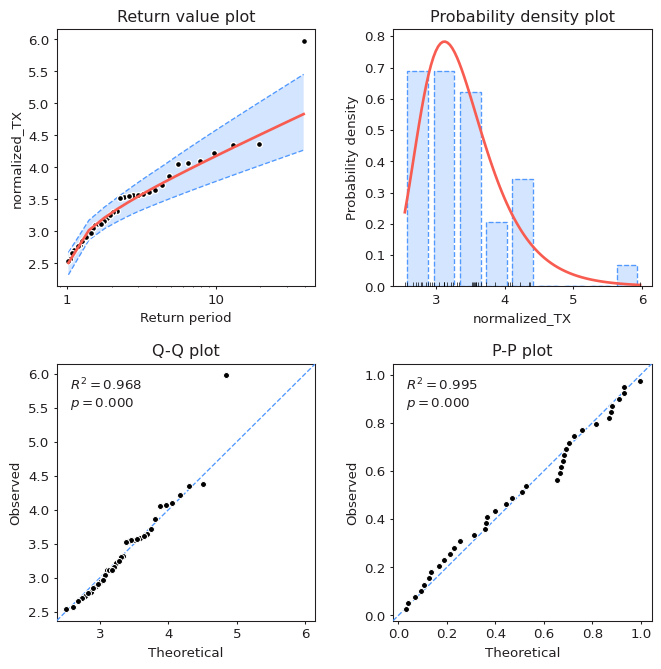

In [359]:
model.plot_diagnostic(alpha=0.95)

> **Q7.** Où se trouve la valeur de la vague de chaleur de Mars 2022 à Concordia ?

> **Q8.** A t elle été utilisée pour calculer le modèle  de temps de retour ?

> **Q9.** D'après le modèle, quel serait son temps de retour théorique  (approximativement) ?

Affichons maintenant les "paramètres" du modèle : 

In [362]:
model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                 normalized_TX      Size:                              12,998
Start:                       January 1985      End:                           April 2022
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 38      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

> **Q10.** Quelle est la distribution du modèle? 

> **Q11.** Est ce qu'on pouvait s'y attendre ?

# **BONUS** - Pour ceux qui ont fini : Recalculez les temps de retour, avec et sans les extrêmes et de façon empirique et avec le modèle pour les anomalies de TX **NON** normalisées (pour ```data['ano_TX']``` à la place de ```data["normalized_TX"]```) et analyser les différences.